# Cell State and Clone Mapping to 10x Visium with spaceTree

This tutorial is based on public data from Janesick et al. 2023: [High resolution mapping of the tumor microenvironment using integrated single-cell, spatial and in situ analysis](https://www.nature.com/articles/s41467-023-43458-x).

In particular, we will use the following files:

- Visium files:
    - Visium HDF5 file 
    - Visium image files
- FRP (scRNA) HDF5 file
- Annotation files:

    - Cell Type annotation file
    - Clone annotation file (based on [infercnvpy](https://github.com/icbi-lab/infercnvpy) run on FRP data) (provided in the `data` folder). We also provide a [tutorial](https://github.com/PMBio/spaceTree/blob/master/notebooks/infercnv_run.ipynb) on how to generate this file.

All data should be downloaded and placed in the `data` folder. You should download the data using the following commands:

```bash
cd data/
# annotation file
wget https://cdn.10xgenomics.com/raw/upload/v1695234604/Xenium%20Preview%20Data/Cell_Barcode_Type_Matrices.xlsx
# scFFPE data
wget https://cf.10xgenomics.com/samples/spatial-exp/2.0.0/CytAssist_FFPE_Human_Breast_Cancer/CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5
# Visium counts data
wget https://cf.10xgenomics.com/samples/cell-exp/7.0.1/Chromium_FFPE_Human_Breast_Cancer_Chromium_FFPE_Human_Breast_Cancer/Chromium_FFPE_Human_Breast_Cancer_Chromium_FFPE_Human_Breast_Cancer_count_sample_filtered_feature_bc_matrix.h5
# Visium spatial data
wget https://cf.10xgenomics.com/samples/spatial-exp/2.0.0/CytAssist_FFPE_Human_Breast_Cancer/CytAssist_FFPE_Human_Breast_Cancer_spatial.tar.gz
# decompressing spatial data
tar -xvzf CytAssist_FFPE_Human_Breast_Cancer_spatial.tar.gz
# renaming tissue_positions file to make it compatable with scanpy
mv spatial/tissue_positions.csv spatial/tissue_positions_list.csv

```




## 0: Imports

In [80]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm
from scipy.spatial import distance
import scvi
from scvi.model.utils import mde
import os
import spaceTree.preprocessing as pp
import spaceTree.dataset as dataset
import warnings
import re
import pickle
import torch
warnings.simplefilter("ignore")

## 1: Prepare the data for spaceTree

### 1.1: Open data files

In [2]:
adata_ref = sc.read_10x_h5('../data/Chromium_FFPE_Human_Breast_Cancer_Chromium_FFPE_Human_Breast_Cancer_count_sample_filtered_feature_bc_matrix.h5')
adata_ref.var_names_make_unique()
cell_type = pd.read_excel("../data/Cell_Barcode_Type_Matrices.xlsx", sheet_name="scFFPE-Seq", index_col = 0)
clone_anno = pd.read_csv("../data/clone_annotation.csv", index_col = 0)

In [4]:
adata_ref.obs = adata_ref.obs.join(cell_type, how="left").join(clone_anno, how="left")

In [5]:
adata_ref.obs.columns = ['cell_type', 'clone']
adata_ref = adata_ref[~adata_ref.obs.cell_type.isna()]

In [12]:
visium = sc.read_visium("../data/", 
                        count_file='CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5')
visium.var_names_make_unique()
visium = pp.convert_array_row_col_to_int(visium)

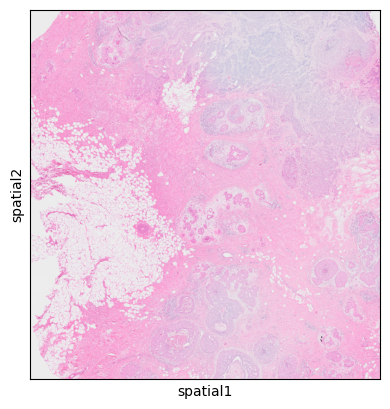

In [13]:
sc.pl.spatial(visium)

## 1.2: Run scvi to remove batch effects and prepare data for knn-graph construction

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 247/247: 100%|██████████| 247/247 [06:23<00:00,  1.46s/it, v_num=1, train_loss_step=8.42e+3, train_loss_epoch=8.08e+3]

`Trainer.fit` stopped: `max_epochs=247` reached.


Epoch 247/247: 100%|██████████| 247/247 [06:23<00:00,  1.55s/it, v_num=1, train_loss_step=8.42e+3, train_loss_epoch=8.08e+3]


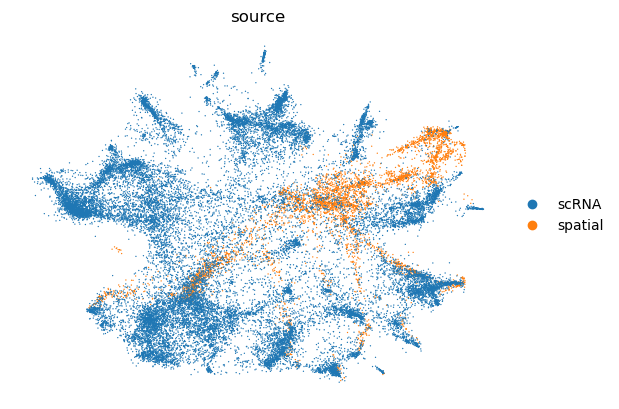

In [16]:
visium.obs["source"] = "spatial"
adata_ref.obs["source"] = "scRNA"
adata = visium.concatenate(adata_ref)
cell_source = pp.run_scvi(adata, "../data/res_scvi.csv")

In [18]:
cell_source.head()

,0,1,source
AACACCTACTATCGAA-1-0,1.525705,0.691050,spatial
AACACGTGCATCGCAC-1-0,0.806706,0.244148,spatial
AACACTTGGCAAGGAA-1-0,0.953750,-0.675919,spatial
AACAGGAAGAGCATAG-1-0,0.539141,0.319413,spatial
AACAGGATTCATAGTT-1-0,0.762749,0.381386,spatial


## 1.3: Construct the knn-graphs

In [61]:
# get rid of the number in the end of the index
cell_source.index = [re.sub(r'-(\d+).*', r'-\1', s) for s in cell_source.index]
emb_spatial =cell_source[cell_source.source == "spatial"][[0,1]]
emb_rna = cell_source[cell_source.source == "scRNA"][[0,1]]

In [49]:
cell_source.head()

,0,1,source
AACACCTACTATCGAA-1,1.525705,0.691050,spatial
AACACGTGCATCGCAC-1,0.806706,0.244148,spatial
AACACTTGGCAAGGAA-1,0.953750,-0.675919,spatial
AACAGGAAGAGCATAG-1,0.539141,0.319413,spatial
AACAGGATTCATAGTT-1,0.762749,0.381386,spatial


In [62]:
visium.obs = visium.obs.drop(columns=["weight"])

1. Recording edges between RNA and spatial embeddings...


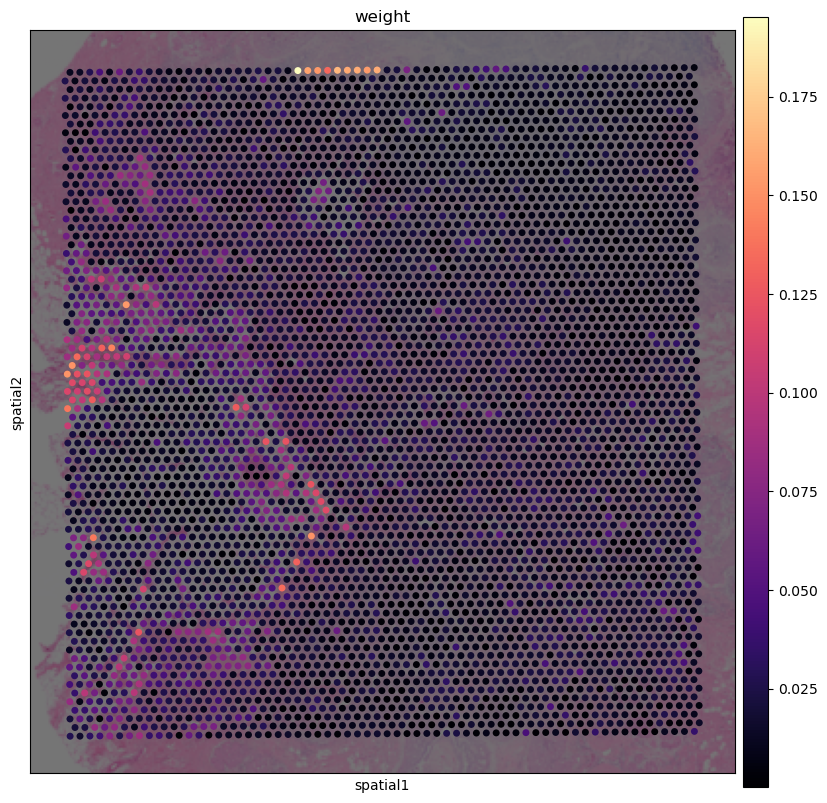

2. Recording edges between RNA embeddings...
3. Creating edges for Visium nodes...


100%|██████████| 4992/4992 [00:09<00:00, 540.17it/s]


4. Saving edges and embeddings...


In [63]:
print("1. Recording edges between RNA and spatial embeddings...")
# 10 here is the number of neighbors to be considered
edges_sc2vis = pp.record_edges(emb_spatial, emb_rna,10, "sc2vis")
# checking where we have the highest distance to refrence data as those might be potentially problematic spots for mapping
pp.show_weights_distribution(edges_sc2vis,visium, 'visium')
edges_sc2vis = pp.normalize_edge_weights(edges_sc2vis)
#%%
print("2. Recording edges between RNA embeddings...")
# 10 here is the number of neighbors to be considered
edges_sc2sc = pp.record_edges(emb_rna,emb_rna, 10, "sc2sc")
edges_sc2sc = pp.normalize_edge_weights(edges_sc2sc)

#%%
print("3. Creating edges for Visium nodes...")
edges_vis2grid = pp.create_edges_for_visium_nodes(visium)
#%%
print("4. Saving edges and embeddings...")
edges = pd.concat([edges_sc2vis, edges_sc2sc, edges_vis2grid])
edges.node1 = edges.node1.astype(str)
edges.node2 = edges.node2.astype(str)

pp.save_edges_and_embeddings(edges, emb_spatial, emb_rna, outdir ="../data/tmp/")

In [64]:
edges.head()

,node1,node2,weight,type
0,TGAGCGATCACTAATC-1,AACACCTACTATCGAA-1,0.909754,sc2vis
1,GATCGATAGGAAGGTA-1,AACACCTACTATCGAA-1,0.909715,sc2vis
2,CAGTATTTCGGCTAGA-1,AACACCTACTATCGAA-1,0.887354,sc2vis
3,AAGGCTTAGTGCCCTG-1,AACACCTACTATCGAA-1,0.860617,sc2vis
4,CCCTTCGGTGACACAA-1,AACACCTACTATCGAA-1,0.857889,sc2vis


Make sure that we have 3 types of edges:
- single-cell (reference) to visium `sc2vis`
- visium to visium `vis2grid`
- single-cell (reference) to single-cell (reference) `sc2sc`

In [65]:
edges["type"].unique()

array(['sc2vis', 'sc2sc', 'vis2grid'], dtype=object)

## 1.4: Create the dataset object for pytorch

For the next step we need to convert node IDs and classes (cell types and clones) into numerial values that can be further used by the model 

In [66]:
#annotation file
annotations = adata_ref.obs[["cell_type", "clone"]].copy().reset_index()
annotations.columns = ["node1", "cell_type", "clone"]
annotations.head()

,node1,cell_type,clone
0,AAACAAGCAAACGGGA-1,Stromal,diploid
1,AAACAAGCAAATAGGA-1,Macrophages 1,1
2,AAACAAGCAACAAGTT-1,Perivascular-Like,diploid
3,AAACAAGCAACCATTC-1,Myoepi ACTA2+,1
4,AAACAAGCAACTAAAC-1,Myoepi ACTA2+,4


In [67]:
# first we ensure that there are no missing values and combine annotations with the edges dataframe
edges_enc, annotations_enc = dataset.preprocess_data(edges, annotations,"sc2vis","vis2grid")


In [72]:
edges_enc.head()

,node1,node2,weight,type,clone,cell_type
0,TGAGCGATCACTAATC-1,AACACCTACTATCGAA-1,0.909754,sc2vis,1,Stromal
1,GATCGATAGGAAGGTA-1,AACACCTACTATCGAA-1,0.909715,sc2vis,1,Stromal
2,CAGTATTTCGGCTAGA-1,AACACCTACTATCGAA-1,0.887354,sc2vis,diploid,Stromal
3,AAGGCTTAGTGCCCTG-1,AACACCTACTATCGAA-1,0.860617,sc2vis,1,T Cell & Tumor Hybrid
4,CCCTTCGGTGACACAA-1,AACACCTACTATCGAA-1,0.857889,sc2vis,1,Stromal


In [68]:
# specify paths to the embeddings that we will use as features for the nodes. Please don't modify unless you previously saved the embeddings in a different location
embedding_paths = {"spatial":f"../data/tmp/embedding_spatial_.csv",
                    "rna":f"../data/tmp/embedding_rna_.csv"}

In [75]:
#next we encode all strings as ingeres and ensure consistancy between the edges and the annotations
emb_vis_nodes, emb_rna_nodes, edges_enc, node_encoder = dataset.read_and_merge_embeddings(embedding_paths, edges_enc)


Excluding 0 clones with less than 10 cells
Excluding 0 cell types with less than 10 cells


In [76]:
edges_enc.head()

,node1,node2,weight,type,clone,cell_type
0,21197,28356,0.909754,sc2vis,1,Stromal
1,6820,28356,0.909715,sc2vis,1,Stromal
2,32167,28356,0.887354,sc2vis,diploid,Stromal
3,11731,28356,0.860617,sc2vis,1,T Cell & Tumor Hybrid
4,1325,28356,0.857889,sc2vis,1,Stromal


In [78]:
#make sure that weight is a float
edges.weight = edges.weight.astype(float)


In [79]:
#Finally creating a pytorch dataset object and a dictionaru that will be used for decoding the data
data, encoding_dict = dataset.create_data_object(edges, emb_vis_nodes, emb_rna_nodes, node_encoder)


In [81]:
torch.save(data, f"../data/tmp/data_visium.pt")
with open(f'../data/tmp/full_encoding_visium.pkl', 'wb') as fp:
    pickle.dump(encoding_dict, fp)